In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
# path = "/content/drive/MyDrive/Sentiment-Analysis-using-BERT-master/Sentiment-Analysis-using-BERT-master/Data/NTC_SV/"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pickle
import pandas as pd

2024-04-15 01:24:05.219242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 01:24:05.460555: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 01:24:06.470594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-15 01:24:06.470634: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missi

In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
df = pd.read_csv("NTC_SV_train.csv")
df_test = pd.read_csv('NTC_SV_test.csv')
# df = pd.concat([df,df_test])
df = df.dropna()
print(df)
print(df_test)

       Unnamed: 0                                             review  label
0               0  đồ_ăn ngon positive hợp_khẩu vị nhiều món nhân...      0
1               1  chè bơ thơm positive có vị ngậy ngậy nhưng lại...      0
2               2  chiều hôm nay mới đi ăn về nghe thiên_hạ đồn q...      0
3               3  mình đặt_hàng qua tin nhắn với cửa_hàng hứa sá...      0
4               4  ghé mấy lần rồi mà không review đi đâu cũng ch...      1
...           ...                                                ...    ...
40756       40756                                              thiếu      0
40757       40757                                                xấu      0
40758       40758                                                 ẩu      0
40759       40759                                                lộn      0
40760       40760                                           hoang_sơ      0

[40760 rows x 3 columns]
      Unnamed: 0                                             r

In [4]:
data = df.review.astype(str).tolist()
label = df.label.tolist()
data_test = df_test.review.astype(str).tolist()
label_test = df_test.label.tolist()

In [ ]:
# import zipfile
# import os

# # Specify the path to the zip file and the extraction directory
# zip_file_path = '/content/drive/MyDrive/glove.zip'  # Change this to your zip file path
# extract_dir = '/content/drive/MyDrive/glove_extracted/'  # Change this to your desired extraction directory

# # Open the zip file and extract its contents
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# # Verify the extracted files (optional)
# print(f'Extracted files: {os.listdir(extract_dir)}')


In [5]:
import pickle
with open("glove.840B.300d.pkl", 'rb') as pickle_file:
    embeddings_index = pickle.load(pickle_file)

In [6]:

tokenizer  = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(data)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

sequences =  tokenizer.texts_to_sequences(data)
# maxlen = max([len(i) for i in data_n])
maxlen = 300
data = pad_sequences(sequences, maxlen=maxlen)

le = LabelEncoder()

label = le.fit_transform(label)
labels = label.reshape(-1,1)
labels_test = le.fit_transform(label_test)
labels_test = labels_test.reshape(-1,1)
# labels = to_categorical(np.asarray(label))
# labels_test = to_categorical(np.asarray(label_test))
print('Shape of data tensor:', data.shape)
x_train,x_val,y_train,y_val = train_test_split(data,labels,test_size=0.15, random_state=48)

unique words : 27954
Shape of data tensor: (40760, 300)


In [7]:
def convert_to_sequences(texts):
  sequences =  tokenizer.texts_to_sequences(texts)
  return pad_sequences(sequences, maxlen=maxlen)

In [8]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
print(300)
print(embedding_matrix.shape)
for word, i in word_index.items():
    # print(word)
    try:
        embedding_vector = embeddings_index['word_vectors'][embeddings_index['dictionary'][word]]
    except KeyError:
        embedding_vector = None
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

300
(27955, 300)


In [9]:
def RNN():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(len(word_index)+1,300,input_length=maxlen)(inputs)
    layer = LSTM(units=256)(layer)
    layer = Dense(256,activation = 'relu')(layer)
    layer = Dense(1,activation='sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [10]:
from keras.callbacks import ModelCheckpoint

model = RNN()
checkpoint = ModelCheckpoint('weights_lstm_NTC_SV_glove_sentece.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.004),metrics=['accuracy'])
model.summary()

2024-04-15 01:26:30.900852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 01:26:38.318463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9639 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5
2024-04-15 01:26:38.320008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9639 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5
2024-04-15 01:26:38.321316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/tas

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          8386500   
                                                                 
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 9,022,917
Trainable params: 9,022,917
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(x_train,y_train,batch_size=128,epochs=2,verbose=1,
          callbacks=[checkpoint], validation_data=[x_val,y_val])

Epoch 1/2


2024-04-15 01:26:49.122677: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8904


271/271 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.8273
Epoch 1: val_accuracy improved from -inf to 0.81338, saving model to weights_lstm_NTC_SV_glove_sentece.hdf5
271/271 [==============================] - 15s 44ms/step - loss: 0.4166 - accuracy: 0.8273 - val_loss: 0.4396 - val_accuracy: 0.8134
Epoch 2/2
269/271 [============================>.] - ETA: 0s - loss: 0.2679 - accuracy: 0.8930
Epoch 2: val_accuracy improved from 0.81338 to 0.88633, saving model to weights_lstm_NTC_SV_glove_sentece.hdf5
271/271 [==============================] - 10s 37ms/step - loss: 0.2678 - accuracy: 0.8931 - val_loss: 0.2804 - val_accuracy: 0.8863


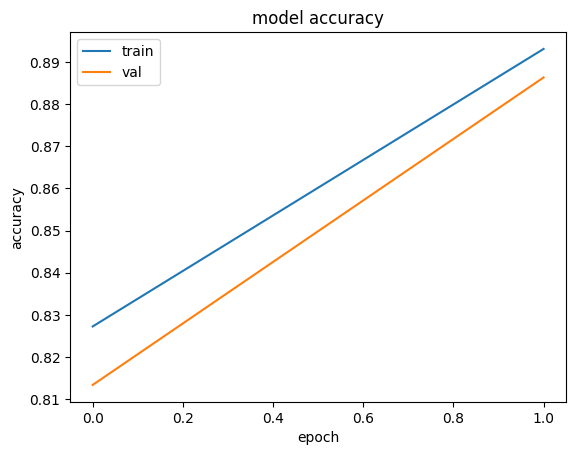

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

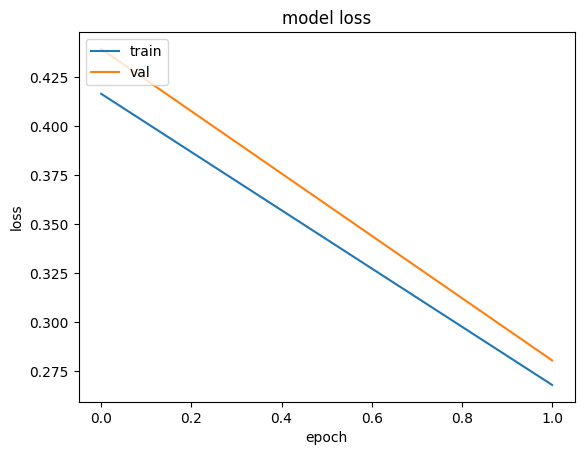

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
from keras.models import load_model
model = load_model('weights_lstm_NTC_SV_glove_sentece.hdf5')
# a = convert_to_sequences(x)
# accr = model.evaluate(a,labels_test)
# print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

In [15]:
from sklearn import metrics
acc = model.predict(convert_to_sequences(data_test))
accr = np.round(acc)
print(metrics.f1_score(labels_test, accr))
print(metrics.precision_score(labels_test, accr))
print(metrics.recall_score(labels_test, accr))

313/313 [==============================] - 3s 8ms/step
0.902108725091894
0.8735481453727988
0.9326


In [16]:
accuracy = metrics.accuracy_score(labels_test, accr)
print("Accuracy:", accuracy)

Accuracy: 0.8988
